<a href="https://colab.research.google.com/github/Daviunb6202/Projetos-CIS-UnB/blob/main/Projeto_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
#Bibliotecas importadas 
Instalar se precisar
#!pip install imbalanced-Learn
#!pip install openpyxl --upgrade --pre
import time
import openpyxl
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing, compose, decomposition, model_selection, pipeline, metrics, ensemble, tree, multiclass
import numpy as np 
import sklearn
import pandas as pd 
import os,sys 
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
#primeira visualização do dataset e separação de X e y
t0 = time.time() 
vinho = pd.read_excel('/content/drive/MyDrive/winequality.xlsx') 
features = vinho.columns
print(vinho[features].isna().sum())
vinho.drop(vinho.columns[0], axis=1, inplace=True)
X = vinho.iloc[:1000,:-2]
y = vinho.iloc[:1000,-2]
y2 = vinho.iloc[:1000,-1]
print(y2)
print(vinho.head()[0:5])
t1 = time.time()
print(f' Tempo gasto: {t1- t0} ')

Unnamed: 0              0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_is_red             0
dtype: int64
0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    1.0
998    0.0
999    0.0
Name: wine_is_red, Length: 1000, dtype: float64
   fixed acidity  volatile acidity  citric acid  ...  alcohol  quality  wine_is_red
0            5.9              0.61         0.08  ...     11.1      6.0          1.0
1            8.2              1.00         0.09  ...      9.0      6.0          1.0
2            6.4              0.24         0.49  ...     10.5      6.0          0.0
3            6.6              0.23         0.26  ...     10.0      6.0          0.0
4            7.2              0.24

In [159]:
#Usando do tecnica de proporcao de labels sinteticas
t0 = time.time()
#Apenas a maioria nao sofrera sampling

smote = SMOTE(k_neighbors =1)
 #Valor do parametro muda conforme o numero de linhas selecionadas do dataset

#o fit_resample e o novo fit ao usar o SMOTE 
X_sm, y_sm = smote.fit_resample(X,y)

#train test split do target multiclasse

#stratify mantem as proporcoes
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_sm, y_sm, test_size = 0.2, random_state=42, stratify=y_sm)
print(y_train.value_counts()) 

t1 = time.time()
print(f' Tempo gasto: {t1- t0} ')

6.0    376
7.0    376
5.0    376
4.0    376
9.0    376
8.0    376
3.0    376
Name: quality, dtype: int64
 Tempo gasto: 0.0296170711517334 


In [153]:
t0 = time.time()
#contabilizacao de ocorrencia de cada caso
class_1 , class_0 = y2.value_counts()

#amostragem de um tipo label a fim de igualar as proporcoes
df_class_0 = vinho[vinho.iloc[:,-1]==0].sample(class_1)
df_class_1 = vinho[vinho.iloc[:,-1]==1]

#novo dataframe corrigido
vinho_balanc = pd.concat([df_class_0, df_class_1], axis=0)

#separacao do novo X e novo target binario
X = vinho_balanc.iloc[:,:-2]
y2 = vinho_balanc.iloc[:,-1]


#Train test split do target binario, proporcao mantida com o stratify

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y2, test_size = 0.2, random_state=42, stratify=y2)
print(y_train.value_counts()) 

t1 = time.time()
print(f' Tempo gasto: {t1- t0} ')
print(np.unique(y_train))

1.0    1279
0.0     620
Name: wine_is_red, dtype: int64
 Tempo gasto: 0.008827447891235352 
[0. 1.]


In [161]:
#Funcoes pre processamento
t0 = time.time()

stand = sklearn.preprocessing.StandardScaler()
padr = sklearn.preprocessing.MinMaxScaler()

X_train_padr = stand.fit_transform(X_train)
X_test_padr = stand.transform(X_test)

X_train_norm = padr.fit_transform(X_train)
X_test_norm = padr.transform(X_test)

t1 = time.time()
print(f' Tempo gasto: {t1- t0} ')

 Tempo gasto: 0.03644371032714844 


In [163]:
#Reducao de dimensionalidade do dataset via PCA 
t0 = time.time() 

pca = sklearn.decomposition.PCA(n_components= 2) 
pcs = pca.fit_transform(X_train_padr)
pcs_df = pd.DataFrame(pcs)
pc_test = pca.transform(X_test_padr)

t1 = time.time() 
print(f' Tempo gasto: {t1- t0} ')

 Tempo gasto: 0.021966934204101562 


 Tempo gasto: 0.2940559387207031 


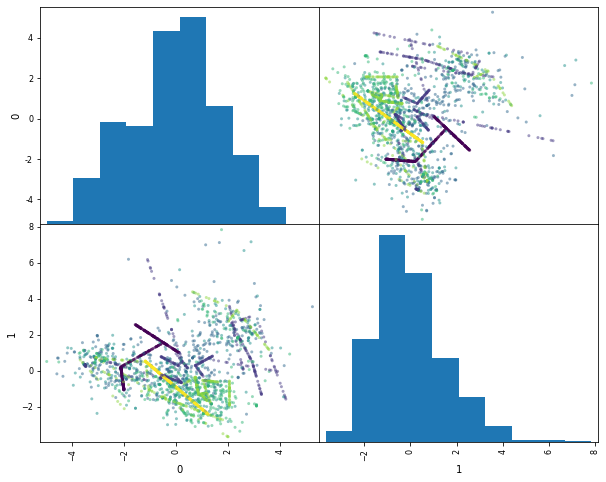

In [121]:
#Correlacoes dos componentes principais
t0 = time.time() 

pd.plotting.scatter_matrix(pcs_df, alpha=0.5, c=y_train, figsize=(10,8))

t1 = time.time() 

print(f' Tempo gasto: {t1- t0} ')

In [122]:

def euclidian_distance(row, X_train):
  m = np.empty(X_train.shape[0])
  for row2 in range(len(np.asarray(X_train)[:,0])):
    m[row2] = np.sqrt(np.sum(np.subtract(row, X_train[row2])**2))
  return m



class knn:
  
  def __init__(self, k):
    self.k = k 

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X2):
    self.X_test = X2
    predicted_labels = self._predict(X2)
    return predicted_labels

  def _predict(self, x):
    predict = np.empty(self.X_test.shape[0])
    for row in range(len(np.asarray(self.X_test)[:,0])):
      dist = euclidian_distance(np.asarray(self.X_test)[row, :], self.X_train)
      indices = np.argsort(dist)[:self.k]
      k_labels = [str(np.asarray(self.y_train.iloc[ind])) for ind in indices]
      most_common = Counter(k_labels).most_common(1)
      predict[row] = float(most_common[0][0])
    return predict

In [162]:
#Para rodar knn 
#Lembrar que pode-se escolher X_train e X_test normatizados e padronizados
t0 = time.time() 

k = knn(k=3)
k.fit(X_train_norm, y_train)
predict = k.predict(X_test_norm)
t1 = time.time() 
print(f' Tempo gasto de knn: {t1- t0} ')
y_score= sklearn.metrics.accuracy_score(y_test, predict)
print(f'acuracia : {y_score.mean()}')

f1 = sklearn.metrics.f1_score(y_test, predict, average = 'macro')
print(f' f1 : {f1} ')

 Tempo gasto de knn: 20.864271879196167 
acuracia : 0.8358662613981763
 f1 : 0.8259193474041177 


In [164]:
#Para rodar X pós PCA no knn
t0 = time.time()

k = knn(k=3)
k.fit(pcs, y_train)
predict = k.predict(pc_test)


t1 = time.time()
print(f' Tempo gasto de knn: {t1- t0} ')
y_score= sklearn.metrics.accuracy_score(y_test, predict)
print(f'acuracia : {y_score.mean()}')
f1 = sklearn.metrics.f1_score(y_test, predict, average = 'macro')
print(f' f1 : {f1} ')

 Tempo gasto de knn: 16.61841344833374 
acuracia : 0.6930091185410334
 f1 : 0.6755080509835211 


              precision    recall  f1-score   support

         3.0       0.99      1.00      0.99        94
         4.0       0.96      1.00      0.98        94
         5.0       0.66      0.67      0.67        94
         6.0       0.58      0.31      0.40        94
         7.0       0.68      0.83      0.75        94
         8.0       0.84      1.00      0.91        94
         9.0       1.00      1.00      1.00        94

    accuracy                           0.83       658
   macro avg       0.82      0.83      0.82       658
weighted avg       0.82      0.83      0.82       658



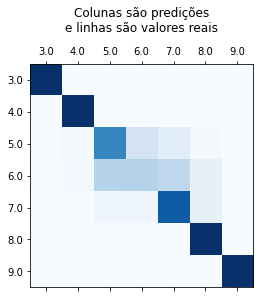

In [150]:
#métricas do knn multiclasse

quant = np.arange(0,7,1)
label = [str(x) for x in np.unique(y_test)]
print(sklearn.metrics.classification_report(y_test, predict))
conf_mx = sklearn.metrics.confusion_matrix(y_test, predict)
plt.matshow(conf_mx, cmap= plt.cm.Blues) 
plt.xticks(quant, label)
plt.yticks(quant, label)
plt.title('Colunas são predições\ne linhas são valores reais\n')
plt.show()

In [157]:
#Métricas para knn binário

print(sklearn.metrics.classification_report(y_test, predict))
print('Colunas são predições\ne linhas são valores reais\n')
print(sklearn.metrics.confusion_matrix(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       155
         1.0       0.99      0.99      0.99       320

    accuracy                           0.98       475
   macro avg       0.98      0.98      0.98       475
weighted avg       0.98      0.98      0.98       475

Colunas são predições
e linhas são valores reais

[[151   4]
 [  4 316]]


In [127]:
#Outro classificador1t0 = time.time()
clf1 = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)
score1 = sklearn.model_selection.cross_val_score(clf1, X_train, y_train, cv=5)
score2 = sklearn.model_selection.cross_val_score(clf1, X_test, y_test, cv=5)
print(score1.mean(),score2.mean())
t1 = time.time()

print(f' Tempo gasto: {t1- t0} ')

0.8461302588004415 0.7537126995142263
 Tempo gasto: 1.0542054176330566 


In [128]:
#Outro classificador 2
t0 = time.time()
clf2 = sklearn.ensemble.ExtraTreesClassifier(n_estimators=10, random_state=42)
score1 = sklearn.model_selection.cross_val_score(clf2, X_train, y_train, cv=5)
score2 = sklearn.model_selection.cross_val_score(clf2, X_test, y_test, cv=5)
print(score1.mean(),score2.mean())
t1 = time.time()

print(f' Tempo gasto: {t1- t0} ')

0.8563841530724886 0.7461369419384687
 Tempo gasto: 0.7146763801574707 


In [129]:
#Outro classificador 3
t0 = time.time()
clf3 = sklearn.tree.DecisionTreeClassifier(max_depth=None, random_state=42)
score1 = sklearn.model_selection.cross_val_score(clf3, X_train, y_train, cv=5)
score2 = sklearn.model_selection.cross_val_score(clf3, X_test, y_test, cv=5)
print(score1.mean(),score2.mean())
t1 = time.time()

print(f' Tempo gasto: {t1- t0} ')

0.7944473705095924 0.6838075410594495
 Tempo gasto: 0.18875503540039062 


In [133]:
#Bagging em cima do melhor classificador multiclasse

bag_model = sklearn.ensemble.BaggingClassifier(clf1,
n_estimators= 100,
max_samples=0.7,
max_features=0.5)
t0 = time.time()
bag_model.fit(X_train_padr, y_train)
t1 = time.time()
score = bag_model.score(X_test_padr, y_test)
print(f' Acurácia: {score} ') 
print(f' Tempo gasto para o bagging: {t1- t0} ')

 Acurácia: 0.8799392097264438 
 Tempo gasto para o bagging: 4.264060974121094 


In [132]:
#Gridsearch dos melhores parametros para o classificador que se saiu melhor entre os 3 abaixo
t0 = time.time()

params = [{'n_estimators': [3,10,30, 50,100], 'max_features': [0.3,0.5,0.7], 'max_samples': [0.3, 0.5, 0.7]}]
grid = sklearn.model_selection.GridSearchCV(bag_model, param_grid = params, cv=5, scoring = 'neg_mean_squared_error', return_train_score =True)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_estimator_)

t1 = time.time()
print(f' Tempo gasto para o gridsearch: {t1- t0} ')
#as melhores medidas do baggingclassifier já foram atualizadas acima!

{'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100} BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=10,
                                                        random_state=42),
                  max_features=0.5, max_samples=0.7, n_estimators=100)
 Tempo gasto para o gridsearch: 303.1578185558319 


In [135]:
#Logistic Regression
log_model = sklearn.linear_model.LogisticRegression(max_iter = 1000000)

log_model.fit(X_train_padr, y_train)
log_predict = log_model.predict(np.asarray(X_test_padr))
print(sklearn.metrics.confusion_matrix(y_test, log_predict))

y_score = sklearn.model_selection.cross_val_score(log_model, X_train, y_train, cv=3, scoring='accuracy')
print(f'acuracia : {y_score.mean()}')

f1 = sklearn.metrics.f1_score(y_test, log_predict, average = 'macro')
print(f' f1 : {f1} ')

print(sklearn.metrics.classification_report(y_test, log_predict))

[[63  9  2 12  0  8  0]
 [ 5 61 22  6  0  0  0]
 [14 24 29 16  4  7  0]
 [16 14 14 19 15 14  2]
 [ 7  5  2 13 34 33  0]
 [10  0  0  1 17 66  0]
 [ 0  0  0  0  0  0 94]]
acuracia : 0.545214799192041
 f1 : 0.5403997549713478 
              precision    recall  f1-score   support

         3.0       0.55      0.67      0.60        94
         4.0       0.54      0.65      0.59        94
         5.0       0.42      0.31      0.36        94
         6.0       0.28      0.20      0.24        94
         7.0       0.49      0.36      0.41        94
         8.0       0.52      0.70      0.59        94
         9.0       0.98      1.00      0.99        94

    accuracy                           0.56       658
   macro avg       0.54      0.56      0.54       658
weighted avg       0.54      0.56      0.54       658



Resultados:

Observação: o dataset teve as proporções de classes balanceadas e, portanto, possui medida de acurácia confiável. Mas devido à demora para rodar o knn em todo dataset, a análise foi feita em cima das primeiras mil linhas, o que deve ter abaixado um pouco as notas.

KNN: com k=3, ofereceu uma acurácia de 0.84 no test set e f1_score de 0.82 para números padronizados. Os resultados são ligeiramente melhores para números normatizados. Durou por volta de 17 segundos.

No plot dos resultados, podemos ver que o maior erro de predição ocorreu nas categorias 5 e 6. Destaque para dificuldade de identificar muitas das labels 6 corretamente(baixo recall).

KNN + PCA: Também usando k=3, houve uma queda de mais de 20% nas duas notas. Mas o PCA originado de normatização performa 1-2% melhor. O tempo de processamento ficou apenas 1 segundo menor.

Já durante o plot dos resultados, ficou evidente a má performance nos valores 5,7,8 e principalmente 6.

Foram usados outros classificadores do modelo de 'trees' para comparação, com seus resultados disponíveis como output. Em cima disso foram rodados um bootstrap agreggator e um GridSearchCV para encontrar seus melhores parâmetros.


--------- Target binário 

KNN:com k=3, ofereceu uma acurácia satisfatória de 0.96 no test set e f1_score de 0.95 para números normatizados. Dessa vez os resultados são ligeiramente melhores para números padronizados. Durou por volta de 9,5 segundos.

KNN + PCA: Também usando k=3, houve uma queda de por volta de 1% apenas nas duas notas. Mas o PCA originado de padronização performa 1-2% melhor. O tempo de processamento ficou apenas meio segundo menor.

Em ambos os plots/métricas, a margem para falsos positivos e falsos negativos foi mínima.

Por fim, foi usado um modelo de regressão logística a fim de comparação.